In [1]:
import numpy as np
import matplotlib.cm as cm
import pandas as pd
from possibilearn.kernel import GaussianKernel
import math
import itertools as it
import gurobipy as gpy

source = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

iris_df = pd.read_csv(
    filepath_or_buffer=source,
    header=None,
    sep=',')

iris_df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
iris_df.dropna(how="all", inplace=True) # drops the empty line at file-end

iris_values = iris_df.iloc[:,:4].values #array dei soli valori
iris_labels = iris_df.iloc[:,4].values #array delle etichette

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

iris_values_std = StandardScaler().fit_transform(iris_values)

pca_2d = PCA(n_components=2)
iris_values_2d = pca_2d.fit_transform(iris_values_std)

pca_3d = PCA(n_components=3)
iris_values_3d = pca_3d.fit_transform(iris_values_std)

pca_4d = PCA(n_components=4)
iris_values_4d = pca_4d.fit_transform(iris_values_std)

# print iris_values_2d

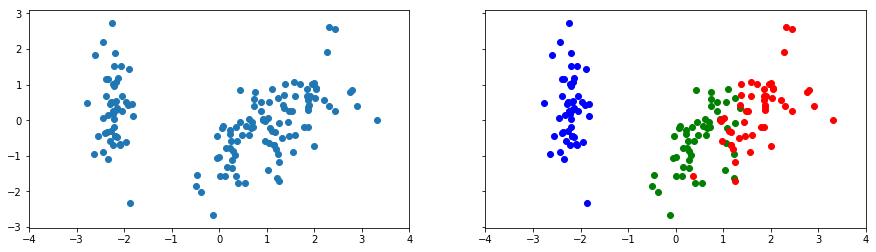

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

iris_values_2d = np.array(iris_values_2d)

fig, axs = plt.subplots(1, 2,
sharey=True, figsize=(15, 4))
fig.subplots_adjust(wspace=0.2)

axs[0].scatter(iris_values_2d[:,0],iris_values_2d[:,1]) #grafico di tutti i punti, senza appartenenza
axs[0].set_xlim(-4,4)

for lab, col in zip(('Iris-setosa', 'Iris-versicolor', 'Iris-virginica'), #grafico con appartenenza
                        ('blue', 'green', 'red')):
        axs[1].scatter(iris_values_2d[iris_labels==lab, 0],
                    iris_values_2d[iris_labels==lab, 1],
                    label=lab,
                    c=col)
axs[1].set_xlim(-4,4)        

plt.show()

In [4]:
def chop(x, minimum, maximum, tolerance=1e-4):
    '''Chops a number when it is sufficiently close to the extreme of
   an enclosing interval.

Arguments:

- x: number to be possibily chopped
- minimum: left extreme of the interval containing x
- maximum: right extreme of the interval containing x
- tolerance: maximum distance in order to chop x

Returns: x if it is farther than tolerance by both minimum and maximum;
         minimum if x is closer than tolerance to minimum
         maximum if x is closer than tolerance to maximum

Throws:

- ValueError if minimum > maximum or if x does not belong to [minimum, maximum]

'''
    if minimum > maximum:
        raise ValueError('Chop: interval extremes not sorted')
    if  x < minimum or x > maximum:
        raise ValueError('Chop: value not belonging to interval')

    if x - minimum < tolerance:
        x = 0
    if maximum - x < tolerance:
        x = maximum
    return x

def solve_wolf(x, k, c):
    '''
    Solves the dual optimization problem on the basis of SV clustering

    - x: array containing data to be clustered
    - k: kernel function to be used
    - c: trade-off parameter
    '''

    n=len(x)
    # p = 1.0 / (n*c)    
    
    model = gpy.Model('Wolf')
    model.setParam('OutputFlag', 0)

    for i in range(n):
        model.addVar(name="beta_%d" %i, lb=0, ub=c, vtype=gpy.GRB.CONTINUOUS)

    model.update()
    b = model.getVars()

    # obj == - SVC(11) 
    obj = gpy.QuadExpr()
    for i, j in it.product(range(n), range(n)):
        obj.add( b[i] * b[j], k.compute(x[i], x[j]))
    
    for i in range(n):
        obj.add( -1 * b[i] * k.compute(x[i], x[i]))
    
    model.setObjective(obj, gpy.GRB.MINIMIZE) #minimizzo -SVC(11) anzichè massimizzare SVC(11)
    
    constEqual = gpy.LinExpr()
    constEqual.add(sum(b), 1.0) # SVC(3)

    model.addConstr(constEqual, gpy.GRB.EQUAL, 1)

    model.optimize()

    b_opt = [chop(v.x, 0, c, 2e-3) for v in model.getVars()]
    
    return b_opt

q = 6.0
sigma = (1.0/(2*q))**0.5
k = GaussianKernel(sigma)
p = 0.6
c = 1.0/(len(iris_values_2d) * p)
beta_opt_2d = solve_wolf(iris_values_2d, k, c)
#beta_opt_3d = solve_wolf(iris_values_3d,7,0.7)
#beta_opt_4d = solve_wolf(iris_values_4d,9,0.75)
c

0.011111111111111112

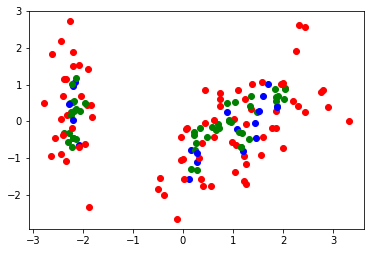

SV are 18


In [5]:
n_sv = 0
n_bsv = 0
index_bsv = []
index_sv = []
index_v = []
for i in range(len(iris_values_2d)):
    if 0 < beta_opt_2d[i] < c:
        plt.plot(iris_values_2d[i][0],iris_values_2d[i][1],'bo')
        n_sv = n_sv + 1
        index_sv.append(i)
    elif beta_opt_2d[i] == c:
        plt.plot(iris_values_2d[i][0],iris_values_2d[i][1],'ro')
        index_bsv.append(i)
    else:
        plt.plot(iris_values_2d[i][0],iris_values_2d[i][1],'go')
        index_v.append(i)

plt.show()
print "SV are %d" %n_sv

In [6]:
def distance_from_center(x_new, x, b_opt, k, gram_term):
    '''
    Computes the squared distance between the image of a point and the center of the found sphere
    
    - x_new: starting point
    - x: array of points to be clustered
    - b_opt: optimal value of variables in the Wolfe dual problem
    - k: kernel function
    - gram_term: common addend based on the Gram matrix
    '''
    
    d1 = k.compute(x_new, x_new)
    d2 = np.array([k.compute(x_i, x_new) for x_i in x]).dot(b_opt)
    d = d1 - 2 * d2 + gram_term
    return d

def squared_radius_and_distance(x, b_opt, k, c):
    '''
    Computes the squared squared radius of the found sphere and a function returning
    the squared distance between the image of a generic point and the sphere center
    
    - x: array of points to be clustered
    - b_opt: optimal value of variables in the Wolfe dual problem
    - k: kernel function
    - c: trade-off parameter
    
    Returns (r, d), where
    
    - r is the squared radius
    - d is the function computing the squared distance
    '''
    
    x_sv = [b for b in b_opt if 0 < b < c]
    gram = np.array(np.array([[k.compute(x1, x2) for x1 in x] for x2 in x]))
    gram_term = np.array(b_opt).dot(gram.dot(b_opt))
    d = lambda x_new: distance_from_center(x_new, x, b_opt, k, gram_term)
    r = [d(sv) for sv in x_sv]
    if len(r) == 0:
        return None
    
    return (np.mean(r), d)



radius, d = squared_radius_and_distance(iris_values_2d, beta_opt_2d, k, c)

print "radius: %f" % radius

radius: 0.985055


In [7]:
def check_couple(x_start, x_end, radius, d, discretization_size=20):
    x_start = np.array(x_start)
    x_end = np.array(x_end)
    discretization = np.arange(0., 1+1./discretization_size, 1./discretization_size)
    for x_between in [alpha*x_start + (1-alpha)*x_end for alpha in discretization]:
        if d(x_between) > radius:
            return 0
    return 1

In [8]:
def check_couple_and_print(x_start, x_end, radius, d, discretization_size=20):
    x_start = np.array(x_start)
    x_end = np.array(x_end)
    discretization = np.arange(0., 1+1./discretization_size, 1./discretization_size)
    for x_between in [alpha*x_start + (1-alpha)*x_end for alpha in discretization]:
        plt.plot(x_between[0],x_between[1],'o')

In [9]:
def get_clusters_opt(x, radius, d):
    
    '''
    Build clusters for the points in x by the optimized method
    
    - x: array of points to be clustered
    - radius: radius of the sphere
    - d: function computing the squared distance between two points
    '''
    
    cl_id = 0
    D = {}
    l = [list(p) for p in x]
    while l != []:
        current = l.pop(0)
        D[cl_id] = [ np.where(x == current)[0][0] ]
        
        for p in l:
            if check_couple(current, p, radius, d) == 1:
                l.remove(p)
                D[cl_id] += [ np.where( x == p)[0][0] ]
                
        cl_id = cl_id +1
    
    return D
    
    

In [10]:
get_clusters_opt(iris_values_2d, radius, d)

{0: [0,
  1,
  3,
  5,
  7,
  9,
  11,
  13,
  16,
  18,
  20,
  23,
  25,
  27,
  29,
  31,
  9,
  36,
  38,
  40,
  42,
  44,
  46,
  48],
 1: [2, 4, 8, 12, 17, 21, 24, 28, 35, 39, 43, 47],
 2: [6, 10, 19, 26, 9, 45],
 3: [14, 30, 49],
 4: [15],
 5: [22],
 6: [32],
 7: [33],
 8: [41],
 9: [50,
  51,
  53,
  55,
  57,
  59,
  61,
  63,
  65,
  67,
  69,
  71,
  73,
  75,
  77,
  79,
  81,
  83,
  86,
  88,
  90,
  92,
  94,
  96,
  99,
  101,
  103,
  105,
  107,
  110,
  112,
  114,
  116,
  119,
  121,
  123,
  125,
  127,
  129,
  132,
  134,
  136,
  138,
  140,
  101,
  144,
  146,
  148],
 10: [52,
  54,
  58,
  64,
  68,
  72,
  76,
  80,
  84,
  87,
  91,
  95,
  100,
  104,
  111,
  115,
  120,
  124,
  128,
  133,
  137,
  141,
  145,
  149],
 11: [56, 62, 70, 78, 89, 97, 102, 113, 126, 135, 143],
 12: [60],
 13: [66, 74, 106, 130, 139],
 14: [82, 147],
 15: [85],
 16: [93],
 17: [98],
 18: [108],
 19: [109],
 20: [117],
 21: [118],
 22: [122],
 23: [131]}

In [11]:
# I cluster sono componenti connesse del grafo con matrice di adiacenza calcolata 
# per ogni coppia con check_couple
#
# 0 --> 1 --> 2 
# Estraggo dalla lista 1, con check_couple trovo che 0 e 1 sono connessi, quindi estraggo 1 dalla lista, quindi
# successivamente non lo controllerò con 2. perdo il collegamento tra 1 e 2
#
# Potrei fare altre passate e fondere due cluster appena trovo una coppia connessa. Quando terminare le passate?

In [12]:
check_couple(iris_values_2d[1], iris_values_2d[2], radius, d )

1

[-2.0864255  -0.65540473]
[-2.26454173  0.5057039 ]


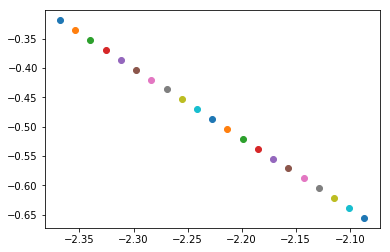

In [13]:
check_couple_and_print(iris_values_2d[1], iris_values_2d[2], radius, d )
print iris_values_2d[1]
print iris_values_2d[0]

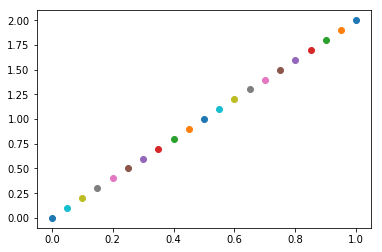

In [14]:
check_couple_and_print([0,0], [1,2], radius, d )

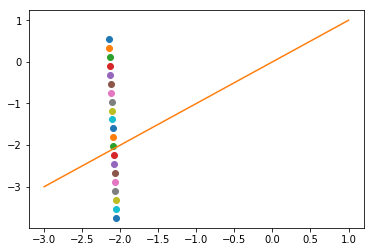

In [15]:
check_couple_and_print([-2.05,-3.75], [-2.15,0.55], radius, d )
plt.plot([-3,1], [-3,1])

In [16]:
'''
def get_clusters_rev(x, radius, d):
    
    cl_id = 0
    D = {}
    l = ([list(p) for p in x])
    l.reverse()
    while l != []:
        current = l.pop(0)
        D[cl_id] = [ np.where(x == current)[0][0] ]
        
        for p in l:
            if check_couple(current, p, radius, d) == 1:
                l.remove(p)
                D[cl_id] += [ np.where( x == p)[0][0] ]
                
        cl_id = cl_id +1
    
    return D
'''

'\ndef get_clusters_rev(x, radius, d):\n    \n    cl_id = 0\n    D = {}\n    l = ([list(p) for p in x])\n    l.reverse()\n    while l != []:\n        current = l.pop(0)\n        D[cl_id] = [ np.where(x == current)[0][0] ]\n        \n        for p in l:\n            if check_couple(current, p, radius, d) == 1:\n                l.remove(p)\n                D[cl_id] += [ np.where( x == p)[0][0] ]\n                \n        cl_id = cl_id +1\n    \n    return D\n'

In [17]:
#get_clusters_rev(iris_values_2d, radius, d)

In [18]:
# Le connessioni che perdo dipendondo dall'ordine con cui considero i punti.

In [19]:
def build_clusters(x, index_v, index_sv, radius, d):
    
    '''
    Build clusters as connected component of the graph which its nodes are the non-BSV points in the 
    dataset. There is an edge between nodes i and j if for all points in the segment connecting i and j the
    squared distance from the center of the sphere is < radius
    
    - x: array of points to be clustered
    - index_v: list/array of the indexes of the non-BSV and non-SV points
    - index_sv: list/array of the indexes of the support vectors
    - radius: radius of the sphere
    - d: function computing the squared distance between two points
    '''
    import networkx as nx
    
    G = nx.Graph()
    G.add_nodes_from(index_v)
    G.add_nodes_from(index_sv)
    
    couples = [[i,j] for i in index_v for j in index_sv]
    
    for c in couples:
        if check_couple(x[c[0]], x[c[1]], radius, d):
            G.add_edge(c[0],c[1])
            
    return [list(c) for c in list(nx.connected_components(G))]

In [20]:
build_clusters(iris_values_2d, index_v, index_sv, radius, d)

[[0,
  1,
  2,
  3,
  7,
  9,
  10,
  12,
  17,
  21,
  24,
  26,
  27,
  28,
  29,
  30,
  34,
  37,
  39,
  40,
  43,
  44,
  48,
  49],
 [129,
  133,
  134,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  145,
  147,
  149,
  54,
  58,
  63,
  65,
  66,
  67,
  69,
  71,
  74,
  75,
  78,
  80,
  82,
  84,
  86,
  89,
  90,
  94,
  96,
  97,
  99,
  100,
  101,
  103,
  110,
  112,
  114,
  115,
  116,
  123,
  124,
  126]]